In [8]:
# [prepare data]
import os
import string
import re
from functools import reduce
from datetime import datetime, timedelta, date
import warnings
import numpy as np
import pandas as pd
from soynlp.tokenizer import RegexTokenizer
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# # [visualization]
# import seaborn as sns
# from matplotlib import rc
# import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'NanumGothic'
# rc('font', weight='bold')
# %matplotlib inline

# [ML]
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, Normalizer, RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, train, XGBRFRegressor
from lightgbm import LGBMRegressor, train

# [DL]
import tensorflow as tf
from tensorflow.keras import layers

ModuleNotFoundError: ignored

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 새로운 dataset

In [6]:
hday_19 = [i.replace(' ','-') for i in ['2019 01 01', '2019 02 04', '2019 02 05', '2019 02 06', '2019 03 01', '2019 05 06', '2019 06 06',
'2019 08 15', '2019 09 12', '2019 08 13', '2019 10 03', '2019 10 09', '2019 12 25', '2020 01 01',]]
hday_20 = [i.replace(' ','-') for i in ['2020 06 06']]

def load_NS():
    train = pd.read_excel('train/sales_train.xlsx', skiprows=1)
    test = pd.read_excel('test/sales_test.xlsx', skiprows=1)
    return train, test

def load_brand():
    return pd.read_excel('brand.xlsx', skiprows=1)

def load_categories():
    return pd.read_csv('0907train_category_datalab.csv')[['ratio', 'sub_cate']]
    
def load_weather(train=False):
    if train:
        return pd.read_csv('2019_weather_dust.csv')
    else:
        return pd.read_csv('2020_weather_dust.csv')

def load_kosis(path, ind_col):
    df = pd.read_excel(path, index_col = ind_col).T.reset_index()
    df['index'] = df['index'].apply(lambda x: x.replace('. ', '-'))
    df.columns = [col_name.strip() for col_name in df.columns]
    return df


def preprocess_NS(df, hday):
    df.columns = ['datetime', 'duration', 'mthcode', 'pdcode', 'pdname', 'pdgroup','unitp', 'sales']

    ######## [date-time related columns] ########
    t = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun'] # 요일
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['mth'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dt_YMD'] = df['datetime'].apply(lambda x: str(x).split()[0])
    df['wday_num'] = df['datetime'].apply(lambda x: x.weekday())
    df['wday'] = df['datetime'].apply(lambda x: t[x.weekday()])
    df['hday'] = df['wday'].apply(lambda x: 0)
    df.loc[(df['dt_YMD'].isin(hday)) | (df['wday'].isin(['sat', 'sun'])), 'hday'] = 1
    df['hour_168'] = df['wday_num']*24 + df['hour']
    df['week_52'] = df['datetime'].apply(lambda x: date(x.year, x.month, x.day).isocalendar()[1] if x < pd.to_datetime('2019-12-30') else 53)
    
    ######## [prime-time] ########
#     df['prime']=0
#     week_prime_morn = [9, 10, 11]
#     week_prime_aft = [16, 17]
#     week_prime_even = [20, 21, 22]
#     week_not_prime = [1,2,3,4,5,6,7,8,12,13,14,15,18,19,23,24]
#     wknd_prime_morn = [8,9,10,11]
#     wknd_prime_aft = [13,14,15,16,17]
#     wknd_prime_even = [21,22]
#     wknd_not_prime = [1,2,3,4,5,6,7,12,18,19,20,23,24]
    
#     df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_morn)), 'prime'] = 'week_prime_morn'
#     df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_aft)), 'prime'] = 'week_prime_aft'
#     df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_even)), 'prime'] = 'week_prime_even'
#     df.loc[(df['hday']==0)&(df['hour'].isin(week_not_prime)), 'prime'] = 'week_not_prime'
#     df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_morn)), 'prime'] = 'wknd_prime_morn'
#     df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_aft)), 'prime'] = 'wknd_prime_aft'
#     df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_even)), 'prime'] = 'wknd_prime_even'
#     df.loc[(df['hday']==1)&(df['hour'].isin(wknd_not_prime)), 'prime'] = 'wknd_not_prime'
    
    
    df['prime'] = 0 # not prime time
    df.loc[((df['hour']>=8) & (df['hour']<=11)),'prime']= 1 # 오전 prime time 
    df.loc[((df['hour']>=14) & (df['hour']<=15)),'prime']= 2 # 오후 prime time 
    df.loc[((df['hour']>=18) & (df['hour']<=23)),'prime']= 3 # 저녁 prime time  
    
    
    ######## [unit-price-bin] ########
    bin_divider=[0, df.unitp.quantile(.25), df.unitp.quantile(.5),\
                 df.unitp.quantile(.75), df.unitp.max()]
                 
    bin_names=['low_price','mid_low_price','mid_high_price','high_price']

    df['unitp_bin']=pd.cut(x=df['unitp'], # 데이터배열
                   bins=bin_divider, # 경계값리스트
                   labels=bin_names, # bin이름
                   include_lowest=True) # 첫 경계값 포함 여부
    df['orders']=df['sales']/df['unitp']
    
    ######## [zapping-time related columns] ########
    duration_df = df.pivot_table(index = ['datetime'], values = 'duration', aggfunc = 'max').reset_index()
    duration_df.columns = ['datetime', 'duration_filled']
    df = pd.merge(df, duration_df, on = 'datetime')
    df['mid_time'] = df['datetime'] + df['duration_filled'].apply(lambda x: timedelta(minutes = x//2))
    df['mid_hour'] = df['mid_time'].dt.hour
    df['mid_minute'] = df['mid_time'].dt.minute
    df['zap_hour'] = (df['mid_time'] + df['mid_minute'].apply(lambda x: timedelta(hours=x//30))).dt.hour
    df['wday_num'] = df['datetime'].apply(lambda x: x.weekday())
    
    
    ######## [weather data merge column] ########
    #df['wth_date'] = df['datetime'].apply(lambda x: str(x)[:-6])
    
    
    ######## [product-name related columns] ########
    df['pdname_token'] = df['pdname'].apply(lambda x: [i for i in RegexTokenizer().tokenize(x) if i not in string.punctuation])
    df['sex'] = df['pdname_token'].apply(lambda x: 'male' if '남성' in x else ('female' if '여성' in x else 'unisex'))
    df['payment'] = df['pdname_token'].apply(lambda x: 'muisa' if ('무이자' in x) or ('무' in x) else ('ilsibul' if ('일시불' in x) or ('일' in x) else 'pay'))
    df['bargain'] = df['pdname'].apply(lambda x: 'bargain' if ('1+1' in x) or ('파격가' in x) or ('특가' in x) or ('인하' in x) or ('세일' in x) else 'same')
    j = re.compile('[\d]+종')
    p = re.compile('[\d]+팩')
    g = re.compile('[\d]+구')
    m = re.compile('[\d]+미')
    iy = re.compile('[\d]+인용')
    bx = re.compile('[\d]+박스')
#     df['jong'] = df['pdname'].apply(lambda x: j.findall(x)[0].replace('종', '') if len(j.findall(x))!=0 else 0)
    df['jong'] = df['pdname'].apply(lambda x: j.findall(x)[0].replace('종', '') if len(j.findall(x))!=0 else
                                    (p.findall(x)[0].replace('팩', '') if len(p.findall(x))!=0 else 
                                     (g.findall(x)[0].replace('구', '') if len(g.findall(x))!=0 else
                                      (m.findall(x)[0].replace('미', '') if len(m.findall(x))!=0 else
                                       (iy.findall(x)[0].replace('인용', '') if len(iy.findall(x))!=0 else
                                        (bx.findall(x)[0].replace('박스', '') if len(bx.findall(x))!=0 else 0
                                        )
                                       )
                                      )
                                     )
                                    )
                                   )
    
    
    ######## [kosis data merge column] ########
    df['index'] = df['datetime'].apply(lambda x: str(x)[:7])
    

    
    return df


def merge_all(df, train = False):
    
    ######## [brand] ########
#     brand = load_brand()[['pd_brand']]
#     df = pd.concat([df, brand], axis = 1)
    
    ######## [category, datalab related columns] ########
    cat = load_categories()
#     df = pd.merge(df, cat, left_on = 'pdcode', right_on = 'p_code')
    df = pd.concat([df, cat], axis = 1)
    
        
    ######## [delete 무형] ########
    df = df[df['pdgroup']!='무형']
    
    ######## [kosis related columns] ########
    sales_type_df = load_kosis('소매업태별_판매액.xlsx', '업태별')
    retail_food_df = load_kosis('소매음식판매액지수_불변지수.xlsx', '업종별')
    ind_type_df = load_kosis('소매업태별_판매액지수_불변지수.xlsx', '업태별')
    ind_pd_kosis_df = load_kosis('업태별상품군_판매액지수_불변지수.xlsx', '업태별상품군').drop(['무점포 소매 총지수'], axis = 1)
    
    sales_type_df.columns = ['index', 'kos_nostore_sales']
    retail_food_df.columns = ['index', 'kos_retail_sales_ind', 'kos_catering']
    ind_type_df.columns = ['index', 'kos_online_shop', 'kos_homeshop']
    
    kosis_df_li = [df, sales_type_df, retail_food_df, ind_type_df] 
    df = reduce(lambda  left, right: pd.merge(left, right, on=['index']), kosis_df_li)
    def input_ind_pdtype_kosis(row): # merge ind_pd_kosis_df
        cat_dict = {'의류': '의복', '속옷': '의복', '주방': '기타상품', '농수축': '음식료품', '이미용': '화장품', '가전': '가전제품', '생활용품': '기타상품',
                   '건강기능': '음식료품', '잡화': '기타상품', '가구': '가구', '침구': '기타상품'}
        pdgroup = row[df.columns.tolist().index('pdgroup')]
        date = row[df.columns.tolist().index('index')]
        row[df.columns.tolist().index('kos_pd_sales_ind')] = ind_pd_kosis_df[ind_pd_kosis_df['index']==date][cat_dict[pdgroup]].values[0]
        return row
    
    df['kos_pd_sales_ind'] = [0]*len(df) 
    df = df.apply(input_ind_pdtype_kosis, axis = 1) 
    
    
    ######## [weather related columns] ########
    if train:
        wther = load_weather(train = True)
    else:
        wther = load_weather(train = False)
    
#     wther = wther[['일시', '기온(°C)', '강수량(mm)', '습도(%)']]
#     wther.columns = ['date', 'temp', 'precp', 'humid']
#     wther['precp'] = wther['precp'].fillna(0)
#     wther['wth_date'] = pd.to_datetime(wther['date']).apply(lambda x: str(x)[:-6])
    df = pd.merge(df, wther, left_on = 'dt_YMD', right_on = 'date')

    return df

In [7]:
# train: 2019. 01 ~ 2019. 12.
# test : 2020. 06
ns_train, ns_test = load_NS()
pp_train, pp_test = preprocess_NS(ns_train, hday_19), preprocess_NS(ns_test, hday_20)

FileNotFoundError: ignored

In [ ]:
train_data = merge_all(pp_train, train = True)
#test = merge_all(pp_test) 

display(train_data.head())
#display(test.head())

,datetime,duration,mthcode,pdcode,pdname,pdgroup,unitp,sales,mth,day,hour,minute,dt_YMD,wday_num,wday,hday,hour_168,week_52,prime,unitp_bin,orders,duration_filled,mid_time,mid_hour,mid_minute,zap_hour,pdname_token,sex,payment,bargain,jong,index,ratio,sub_cate,kos_nostore_sales,kos_retail_sales_ind,kos_catering,kos_online_shop,kos_homeshop,kos_pd_sales_ind,date,temp_daegu,maxtemp_daegu,mintemp_daegu,dailycross_daegu,precip_daegu,humid_daegu,cloud_daegu,temp_incheon,maxtemp_incheon,mintemp_incheon,dailycross_incheon,precip_incheon,humid_incheon,cloud_incheon,temp_daejeon,maxtemp_daejeon,mintemp_daejeon,dailycross_daejeon,precip_daejeon,humid_daejeon,cloud_daejeon,temp_busan,maxtemp_busan,mintemp_busan,dailycross_busan,precip_busan,humid_busan,cloud_busan,temp_seoul,maxtemp_seoul,mintemp_seoul,dailycross_seoul,precip_seoul,humid_seoul,cloud_seoul,temp_gwangju,maxtemp_gwangju,mintemp_gwangju,dailycross_gwangju,precip_gwangju,humid_gwangju,cloud_gwangju,finedust
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,0,2019-01-01,1,tue,1,30,1,0,low_price,52.606516,20.0,2019-01-01 06:10:00,6,10,6,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01,-0.6,3.4,-3.0,6.4,0.0,49,3.6,-4.4,-0.9,-7.2,6.3,0.0,58,2.5,-2.7,0.7,-6.1,6.8,0.1,70,7.1,1.0,5.5,-1.9,7.4,0.0,42,0.4,-5.0,-0.6,-8.2,7.6,0.0,50,3.4,0.0,2.4,-2.3,4.7,0.0,65,7.9,38
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,0,2019-01-01,1,tue,1,30,1,0,low_price,109.548872,20.0,2019-01-01 06:10:00,6,10,6,"[테이트, 여성, 셀린니트, 3, 종]",female,pay,same,3,2019-01,59.40921,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01,-0.6,3.4,-3.0,6.4,0.0,49,3.6,-4.4,-0.9,-7.2,6.3,0.0,58,2.5,-2.7,0.7,-6.1,6.8,0.1,70,7.1,1.0,5.5,-1.9,7.4,0.0,42,0.4,-5.0,-0.6,-8.2,7.6,0.0,50,3.4,0.0,2.4,-2.3,4.7,0.0,65,7.9,38
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,20,2019-01-01,1,tue,1,30,1,0,low_price,81.754386,20.0,2019-01-01 06:30:00,6,30,7,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01,-0.6,3.4,-3.0,6.4,0.0,49,3.6,-4.4,-0.9,-7.2,6.3,0.0,58,2.5,-2.7,0.7,-6.1,6.8,0.1,70,7.1,1.0,5.5,-1.9,7.4,0.0,42,0.4,-5.0,-0.6,-8.2,7.6,0.0,50,3.4,0.0,2.4,-2.3,4.7,0.0,65,7.9,38
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,20,2019-01-01,1,tue,1,30,1,0,low_price,174.310777,20.0,2019-01-01 06:30:00,6,30,7,"[테이트, 여성, 셀린니트, 3, 종]",female,pay,same,3,2019-01,59.40921,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01,-0.6,3.4,-3.0,6.4,0.0,49,3.6,-4.4,-0.9,-7.2,6.3,0.0,58,2.5,-2.7,0.7,-6.1,6.8,0.1,70,7.1,1.0,5.5,-1.9,7.4,0.0,42,0.4,-5.0,-0.6,-8.2,7.6,0.0,50,3.4,0.0,2.4,-2.3,4.7,0.0,65,7.9,38
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,40,2019-01-01,1,tue,1,30,1,0,low_price,167.218045,20.0,2019-01-01 06:50:00,6,50,7,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01,-0.6,3.4,-3.0,6.4,0.0,49,3.6,-4.4,-0.9,-7.2,6.3,0.0,58,2.5,-2.7,0.7,-6.1,6.8,0.1,70,7.1,1.0,5.5,-1.9,7.4,0.0,42,0.4,-5.0,-0.6,-8.2,7.6,0.0,50,3.4,0.0,2.4,-2.3,4.7,0.0,65,7.9,38


In [ ]:
train_data['part'] = 0
train_data['part_pk'] = train_data['dt_YMD'] + train_data['pdcode'].apply(lambda x: str(x))

In [ ]:
for pk in train_data['part_pk'].unique():
    df = train_data[train_data['part_pk']==pk]
    num = len(df)
    train_data.loc[train_data['part_pk']==pk, 'part'] = [i/num for i in range(1, num+1)]

결측치 input - knn

In [ ]:
use_features = ['unitp', 'jong', 'ratio', 
                    'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop', 'kos_homeshop', 'kos_pd_sales_ind',
                    'temp_daegu', 'maxtemp_daegu', 'mintemp_daegu', 'dailycross_daegu',
                    'precip_daegu', 'humid_daegu', 'cloud_daegu', 'temp_incheon',
                    'maxtemp_incheon', 'mintemp_incheon', 'dailycross_incheon',
                    'precip_incheon', 'humid_incheon', 'cloud_incheon', 'temp_daejeon',
                    'maxtemp_daejeon', 'mintemp_daejeon', 'dailycross_daejeon',
                    'precip_daejeon', 'humid_daejeon', 'cloud_daejeon', 'temp_busan',
                    'maxtemp_busan', 'mintemp_busan', 'dailycross_busan', 'precip_busan',
                    'humid_busan', 'cloud_busan', 'temp_seoul', 'maxtemp_seoul',
                    'mintemp_seoul', 'dailycross_seoul', 'precip_seoul', 'humid_seoul',
                    'cloud_seoul', 'temp_gwangju', 'maxtemp_gwangju', 'mintemp_gwangju',
                    'dailycross_gwangju', 'precip_gwangju', 'humid_gwangju',
                    'cloud_gwangju', 'finedust', # numerical
                    'mthcode', 'pdcode', 
                    'pdgroup', 
                    'mth', 'day', 'hour', 'minute', 'wday', 'hday', 'hour_168', 'week_52', 'prime',
                    'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate', 'part', # categorical(ohe)
                    'unitp_bin', # categorical(ordinal)
                    'sales'] # target
    
numeric_features = ['unitp', 'jong', 'ratio', 'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop',
                    'kos_homeshop', 'kos_pd_sales_ind','temp_daegu', 'maxtemp_daegu', 'mintemp_daegu', 'dailycross_daegu',
                    'precip_daegu', 'humid_daegu', 'cloud_daegu', 'temp_incheon',
                    'maxtemp_incheon', 'mintemp_incheon', 'dailycross_incheon',
                    'precip_incheon', 'humid_incheon', 'cloud_incheon', 'temp_daejeon',
                    'maxtemp_daejeon', 'mintemp_daejeon', 'dailycross_daejeon',
                    'precip_daejeon', 'humid_daejeon', 'cloud_daejeon', 'temp_busan',
                    'maxtemp_busan', 'mintemp_busan', 'dailycross_busan', 'precip_busan',
                    'humid_busan', 'cloud_busan', 'temp_seoul', 'maxtemp_seoul',
                    'mintemp_seoul', 'dailycross_seoul', 'precip_seoul', 'humid_seoul',
                    'cloud_seoul', 'temp_gwangju', 'maxtemp_gwangju', 'mintemp_gwangju',
                    'dailycross_gwangju', 'precip_gwangju', 'humid_gwangju',
                    'cloud_gwangju', 'finedust',
                    ]

cat_ohe_features = ['mthcode', 'pdcode', 'pdgroup', 
                    'mth', 'day', 'hour', 'minute', 'wday', 'hday', 'hour_168', 'week_52', 'prime',
                   'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate', 'part']

cat_ord_features = ['unitp_bin']

def astype_cols(df):
    """returns 'columns type properly changed X"""
    for numft in numeric_features:
        df[numft] = df[numft].astype(np.float64)
    for catoheft in cat_ohe_features:
        df[catoheft] = df[catoheft].astype(str)
    for catordft in cat_ord_features:
        df[catordft] = df[catordft].astype(str)
    return df

def get_pipeline():
    """returns 'Pipeline' """
    global use_features, numeric_features, cat_ohe_features, cat_ord_features

    ss = StandardScaler()
    # mm = MinMaxScaler((0, 1))

    numeric_transformer = Pipeline(steps=[
    #    ('scaler', mm),
        ('scaler', ss),
    ])

    cat_ohe_transformer = Pipeline(steps=[
        ('onehot_enc', OneHotEncoder(handle_unknown='ignore'))])


    cat_ord_transformer = Pipeline(steps=[
        ('ordinal_enc', OrdinalEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat_ohe', cat_ohe_transformer, cat_ohe_features),
            ('cat_lbl', cat_ord_transformer, cat_ord_features)])

    prep_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    return prep_pipe

X = train_data[use_features].dropna().drop(['sales'], axis = 1).reset_index(drop=True)
y = train_data[use_features].dropna()['sales'].reset_index(drop=True)

In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
knn = KNeighborsRegressor(4, weights = 'distance')
# knnx = prep_pipe.fit_transform(X)
knn_pipe = get_pipeline()
knnx = knn_pipe.fit_transform(astype_cols(X))
knny = y

knn.fit(knnx, np.log1p(knny))

df_missing_sales = train_data[train_data['sales'].isnull()][use_features].drop(['sales'], axis = 1)
df_missing_sales = astype_cols(df_missing_sales)

imputed_sales = np.exp(knn.predict(knn_pipe.transform(df_missing_sales)))
imputed_sales

array([ 7550226.15978033, 10829163.64496391,  9543920.60645786, ...,
       19117419.97231652,  5510860.64105574,  6351388.23719007])

In [ ]:
imputed_train_data = train_data[use_features].reset_index(drop=True)
imputed_train_data.loc[imputed_train_data['sales'].isnull(),'sales'] = imputed_sales

X = imputed_train_data.drop(['sales'], axis = 1).reset_index(drop=True)
X = astype_cols(X)

y = imputed_train_data['sales'].reset_index(drop=True)

### Main

In [ ]:
use_features = ['unitp', 'jong', 'ratio', 
                    'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop', 'kos_homeshop', 'kos_pd_sales_ind',
                    'temp_daegu', 'maxtemp_daegu', 'mintemp_daegu', 'dailycross_daegu',
                    'precip_daegu', 'humid_daegu', 'cloud_daegu', 'temp_incheon',
                    'maxtemp_incheon', 'mintemp_incheon', 'dailycross_incheon',
                    'precip_incheon', 'humid_incheon', 'cloud_incheon', 'temp_daejeon',
                    'maxtemp_daejeon', 'mintemp_daejeon', 'dailycross_daejeon',
                    'precip_daejeon', 'humid_daejeon', 'cloud_daejeon', 'temp_busan',
                    'maxtemp_busan', 'mintemp_busan', 'dailycross_busan', 'precip_busan',
                    'humid_busan', 'cloud_busan', 'temp_seoul', 'maxtemp_seoul',
                    'mintemp_seoul', 'dailycross_seoul', 'precip_seoul', 'humid_seoul',
                    'cloud_seoul', 'temp_gwangju', 'maxtemp_gwangju', 'mintemp_gwangju',
                    'dailycross_gwangju', 'precip_gwangju', 'humid_gwangju',
                    'cloud_gwangju', 'finedust', # numerical
                    #'mthcode', 'pdcode', 
                    'pdgroup', 
                    'mth', 'day', 'hour', 'minute', 'wday', 'hday', 
                    #'hour_168', 'week_52', 'prime',
                    'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate', 
                    'part', # categorical(ohe)
                    'unitp_bin', # categorical(ordinal)
                    'sales'] # target
    
numeric_features = ['unitp', 'jong', 'ratio', 'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop',
                    'kos_homeshop', 'kos_pd_sales_ind','temp_daegu', 'maxtemp_daegu', 'mintemp_daegu', 'dailycross_daegu',
                    'precip_daegu', 'humid_daegu', 'cloud_daegu', 'temp_incheon',
                    'maxtemp_incheon', 'mintemp_incheon', 'dailycross_incheon',
                    'precip_incheon', 'humid_incheon', 'cloud_incheon', 'temp_daejeon',
                    'maxtemp_daejeon', 'mintemp_daejeon', 'dailycross_daejeon',
                    'precip_daejeon', 'humid_daejeon', 'cloud_daejeon', 'temp_busan',
                    'maxtemp_busan', 'mintemp_busan', 'dailycross_busan', 'precip_busan',
                    'humid_busan', 'cloud_busan', 'temp_seoul', 'maxtemp_seoul',
                    'mintemp_seoul', 'dailycross_seoul', 'precip_seoul', 'humid_seoul',
                    'cloud_seoul', 'temp_gwangju', 'maxtemp_gwangju', 'mintemp_gwangju',
                    'dailycross_gwangju', 'precip_gwangju', 'humid_gwangju',
                    'cloud_gwangju', 'finedust',
                    ]

cat_ohe_features = [
                  #  'mthcode', 'pdcode',
                    'pdgroup', 
                    'mth', 'day', 'hour', 'minute', 'wday', 'hday', 
                  #  'hour_168', 'week_52', 'prime',
                   'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate', 
                   'part'
                    ]
cat_ord_features = ['unitp_bin']

def get_pipeline():
    """returns 'Pipeline' """
    global use_features, numeric_features, cat_ohe_features, cat_ord_features

    ss = StandardScaler()
    # mm = MinMaxScaler((0, 1))

    numeric_transformer = Pipeline(steps=[
    #    ('scaler', mm),
        ('scaler', ss),
    ])

    cat_ohe_transformer = Pipeline(steps=[
        ('onehot_enc', OneHotEncoder(handle_unknown='ignore'))])


    cat_ord_transformer = Pipeline(steps=[
        ('ordinal_enc', OrdinalEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat_ohe', cat_ohe_transformer, cat_ohe_features),
            ('cat_lbl', cat_ord_transformer, cat_ord_features)])

    prep_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
    return prep_pipe

imputed_train_data = train_data[use_features].reset_index(drop=True)
imputed_train_data.loc[imputed_train_data['sales'].isnull(),'sales'] = imputed_sales

X = imputed_train_data.drop(['sales'], axis = 1).reset_index(drop=True)
X = astype_cols(X)

y = imputed_train_data['sales'].reset_index(drop=True)
y = np.log1p(y)

lgbmr = LGBMRegressor(n_estimators = 2000, 
                      max_depth = 17, 
                      learning_rate= 0.32,
                      colsample_bytree = 0.7,
                      #reg_lambda = .5,
                     gamma = 1
                     )
#rf = RandomForestRegressor()

model = lgbmr

prep_pipe = get_pipeline()

MAPE_li = []
k_fold = KFold(n_splits=5, shuffle=True, random_state = 2020)

# prep_pipe.fit(X)
for train_idx, val_idx in k_fold.split(X):
    X_train, y_train = X.iloc[train_idx ,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    
    X_train = prep_pipe.fit_transform(X_train)
    X_val = prep_pipe.transform(X_val)
    
#     reg = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('regressor', model)])
    #model.fit(X_train, y_train)
    model.fit(X_train, np.log1p(y_train))
    
    y_pred = model.predict(X_val)
    #mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    mape = np.mean(np.abs((y_val - np.expm1(y_pred)) / y_val)) * 100
    MAPE_li.append(mape)
    print('{}~{}'.format(train_idx, val_idx), 'MAPE :', mape)
    
    
print('\nAVG_MAPE', np.mean(MAPE_li))

[    0     1     2 ... 37365 37366 37367]~[    8    11    15 ... 37338 37355 37357] MAPE : 2.1529893778388027
[    0     1     2 ... 37363 37364 37365]~[    5    14    17 ... 37359 37366 37367] MAPE : 2.1133499735932144
[    0     2     3 ... 37365 37366 37367]~[    1    10    13 ... 37356 37360 37362] MAPE : 2.115785968566512
[    1     5     6 ... 37364 37366 37367]~[    0     2     3 ... 37351 37361 37365] MAPE : 2.100293030924956
[    0     1     2 ... 37365 37366 37367]~[    6     7    12 ... 37358 37363 37364] MAPE : 2.139126295605278

AVG_MAPE 2.1243089293057524


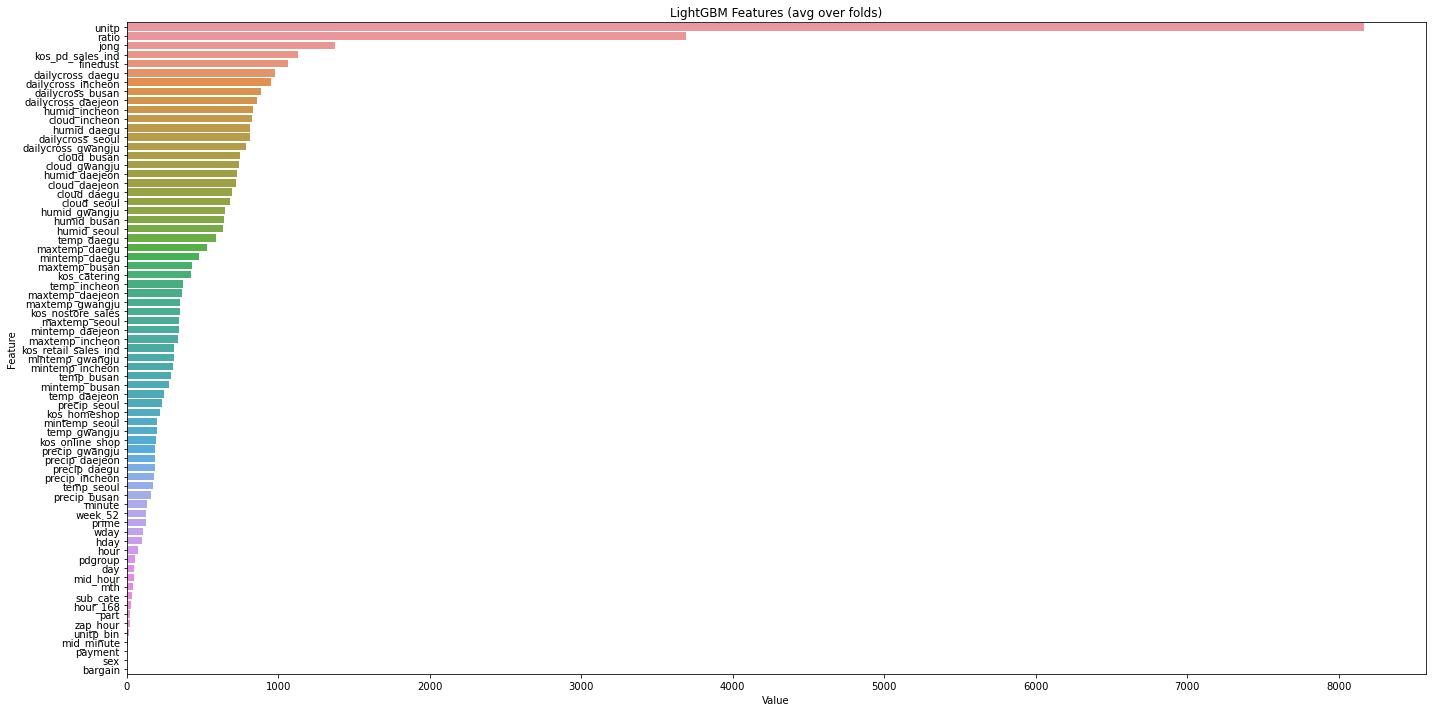

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')